## Import modules

In [1]:
from common_dirs_fns import *
from ngs_functions import *
import pandas as pd
import numpy as np
import regex
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
from collections import Counter
from Bio.Seq import Seq

# For progress bars
from tqdm.notebook import tqdm
tqdm.pandas()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Specify matplotlib formatting
%matplotlib inline
mpl.rcParams['svg.fonttype'] ='none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 7})

## Use FLASH to combine forward and reverse reads

In [3]:
# Directory to save FLASH output
flash_out = ngs_path + 'flash_out_pre-sort'

# Forward and reverse reads to combine with FLASH
flash_in1 = ngs_path + 'pre-sort_library_R1.fastq'
flash_in2 = ngs_path + 'pre-sort_library_R2.fastq'

In [4]:
# Generate a dataframe that counts all of the unique paired-end reads
merged_reads_df = count_paired_end_reads(flash_in1, flash_in2, flash_out)

"FLASH-1.2.11-windows-bin/flash"  --max-overlap=150 --min-overlap=10 --output-directory=NGS/flash_out_pre-sort --max-mismatch-density=0.1 "NGS/pre-sort_library_R1.fastq" "NGS/pre-sort_library_R2.fastq"
>>> [FLASH] Starting FLASH v1.2.11
>>> [FLASH] Fast Length Adjustment of SHort reads
>>> [FLASH]
>>> [FLASH] Input files:
>>> [FLASH]     NGS/pre-sort_library_R1.fastq
>>> [FLASH]     NGS/pre-sort_library_R2.fastq
>>> [FLASH]
>>> [FLASH] Output files:
>>> [FLASH]     NGS/flash_out_pre-sort/out.extendedFrags.fastq
>>> [FLASH]     NGS/flash_out_pre-sort/out.notCombined_1.fastq
>>> [FLASH]     NGS/flash_out_pre-sort/out.notCombined_2.fastq
>>> [FLASH]     NGS/flash_out_pre-sort/out.hist
>>> [FLASH]     NGS/flash_out_pre-sort/out.histogram
>>> [FLASH]
>>> [FLASH] Parameters:
>>> [FLASH]     Min overlap:           10
>>> [FLASH]     Max overlap:           150
>>> [FLASH]     Max mismatch density:  0.100000
>>> [FLASH]     Allow "outie" pairs:   false
>>> [FLASH]     Cap mismatch quals:    fal

## Manually specify sequence information for read processing

In [5]:
# Forward and reverse primer binding sites
fwd_primer = 'ttcggcatggggtcaggtg'.upper()
rev_primer = 'agctgcgggtatcggagga'.upper()

# Up to two errors are allowed in the primer binding site
primer_mismatches = 2

'''
Searching for rev_primer_regex will return the sequence that occurs after the primer binding site
See Python re documentation (https://docs.python.org/3/library/re.html) for reference to (?<=...) notation
ACA = first three nucleotides after primer binding site in all library constructs
'''
rev_primer_regex = regex.compile('(?<=('+rev_primer+'){e<='+str(primer_mismatches)+'}ACA)')

## Apply processing functions to merged_reads_df

In [6]:
def process_data(seq):
    # Reverse complement
    rc = str(Seq(seq).reverse_complement())
    
    # Find DNA sequence that encodes peptide
    after_rev_f = find_after_rev_primer(seq, rev_primer_regex)
    after_rev_r = find_after_rev_primer(rc, rev_primer_regex)
    after_rev = consensus_after_rev_primer(after_rev_f, after_rev_r)
    
    # Translate DNA sequence
    raw_tln = raw_translation(after_rev)
    tln = actual_translation(raw_tln)
    
    return [rc,
            after_rev_f,after_rev_r,after_rev,
            raw_tln, tln]

In [7]:
new_cols = ['MergedRC',
            'AfterRevPrimerF','AfterRevPrimerR','AfterRevPrimer',
            'TlnRaw','Translation']

merged_reads_df[new_cols] = pd.DataFrame([[None]*len(new_cols)], index=merged_reads_df.index)

merged_reads_df.loc[:,new_cols] = merged_reads_df.loc[:].progress_apply(lambda x: process_data(x['Merged']),
                                                                          axis=1, result_type='expand').values

C:\ProgramData\Anaconda3\lib\site-packages\Bio\Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


## Add pre-sort data as a new bin to post-sort dataframe

In [8]:
merged_reads_df['Bin'] = 'Pre-sort'
pre_post_df = pd.crosstab(merged_reads_df['Translation'],
                       merged_reads_df['Bin'],
                       values=merged_reads_df['Count'],
                       aggfunc=sum)

pre_post_df.columns = pd.MultiIndex.from_product([['Count'],pre_post_df.columns])
pre_post_df[('Frequency', 'Pre-sort')] = pre_post_df[('Count', 'Pre-sort')].divide(
                                                pre_post_df[('Count', 'Pre-sort')].sum())

# Import tln_count_df, which was generated in NGS_data
tln_count_df = pd.read_csv(analysis_path+'tln_count_df.csv',index_col=[0,1],header=[0,1],na_filter=False)
tln_count_df.index = tln_count_df.index.levels[0]

pre_post_df = pre_post_df.join(tln_count_df, how='outer')
pre_post_df = pre_post_df.sort_index(axis=1)

# Import human AMP peptide information scraped from APD3
peptides_df = pd.read_excel(peptides_df_path,index_col=0)

# Note which peptides were designed into the human AMP library
pre_post_df['InLibrary'] = pre_post_df.index.isin(peptides_df['Sequence'])
pre_post_df.loc[['', '*'], 'InLibrary'] = None

## Plot peptide frequencies pre- and post-sort-seq workflow

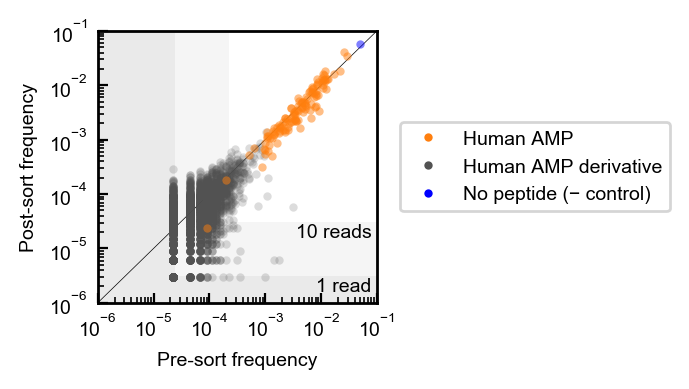

In [9]:
import matplotlib.patches as mpatches

plt.figure(figsize=(1.8,1.8), dpi=200)
ax = plt.subplot()

# Plot human AMPs
plt.plot(pre_post_df.loc[pre_post_df['InLibrary']==1, ('Frequency', 'Pre-sort')],
         pre_post_df.loc[pre_post_df['InLibrary']==1, ('Frequency', 'FSC-BSC')],
         linestyle='',marker='.',alpha=0.5,zorder=1,color='C1',markersize=6, markeredgewidth=0)

# Plot human AMP derivatives
plt.plot(pre_post_df.loc[pre_post_df['InLibrary']==0, ('Frequency', 'Pre-sort')],
         pre_post_df.loc[pre_post_df['InLibrary']==0, ('Frequency', 'FSC-BSC')],
         linestyle='',marker='.',alpha=0.2,zorder=0,color='#525252',markersize=6, markeredgewidth=0)

# Plot no peptide control
plt.plot(pre_post_df.loc[pre_post_df.index.isin(['*']), ('Frequency', 'Pre-sort')],
         pre_post_df.loc[pre_post_df.index.isin(['*']), ('Frequency', 'FSC-BSC')],
         linestyle='',marker='.',alpha=0.5,zorder=1,color='b',markersize=6, markeredgewidth=0)

# Set axis limits and plot 1:1 line
plt.xscale('log')
plt.yscale('log')
axlim = [10**-6,0.1]
ax.set_xlim(axlim)
ax.set_ylim(axlim)
plt.plot(axlim,axlim,color='k',zorder=-0.5,linewidth=0.25)

pre_sort_lowest_freq = 1/pre_post_df[('Count', 'Pre-sort')].sum()
post_sort_lowest_freq = 1/pre_post_df[('Count', 'FSC-BSC')].sum()

# Plot 1 read and 10 read spans
plt.axvspan(axlim[0], pre_sort_lowest_freq, color='#f0f0f0', zorder=-1)
plt.axhspan(axlim[0], post_sort_lowest_freq, color='#f0f0f0', zorder=-1)

plt.axvspan(axlim[0], 10*pre_sort_lowest_freq,
            color='#d9d9d9',alpha=0.25,linewidth=0,zorder=-1)

ax.add_patch(mpatches.Polygon(np.array([[10*pre_sort_lowest_freq, axlim[0]],
                                        [axlim[1], axlim[0]],
                                        [axlim[1], 10*post_sort_lowest_freq],
                                        [10*pre_sort_lowest_freq, 10*post_sort_lowest_freq]]),
                              color='#d9d9d9',alpha=0.25,linewidth=0,zorder=-1))

# Set tick parameters
plt.xticks(10**np.linspace(-6, -1, 6))
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base = 10.0,
                                                 subs = np.arange(1.0, 10.0) * 0.1,
                                                 numticks = 10))

plt.tick_params(which='both', axis='both', direction='in')

# Label 1 read and 10 read spans
plt.text(0.08, post_sort_lowest_freq*0.95, '1 read',
         verticalalignment='top', horizontalalignment='right')

plt.text(0.08, 10*post_sort_lowest_freq*0.95, '10 reads',
         verticalalignment='top', horizontalalignment='right')


# Create a legend
leg = plt.legend(labels=['Human AMP', 'Human AMP derivative', 'No peptide (− control)'],
           loc='center left', bbox_to_anchor=[1.05, 0.5])

for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)


plt.xlabel('Pre-sort frequency')
plt.ylabel('Post-sort frequency')
plt.savefig(figures_path+'pre_post_sort_freq.svg', bbox_inches='tight')

## Save processed pre-sort data to a CSV file

In [10]:
pre_post_df.swaplevel(axis=1)['Pre-sort'].dropna().to_csv(analysis_path+'pre-sort_processed.csv')

In [11]:
post_sort_processed = pre_post_df.swaplevel(axis=1)['FSC-BSC'].dropna()
post_sort_processed = post_sort_processed[post_sort_processed['Count']!=0]

post_sort_processed.to_csv(analysis_path+'post-sort_processed.csv')